# In this notebook we are going to build a music recommendation engine that would reccomend artists based on the lyrics of their songs. 

### First off we import our libraries

In [1]:
import lyricsgenius
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
import requests
from urllib.request import urlopen
import bs4
from bs4 import BeautifulSoup
import re
import lxml.html
from lxml import html
from datetime import datetime, timedelta
import time
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import json
import boto3
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

nltk.download('stopwords')
stop = stopwords.words('english')
sno = SnowballStemmer('english')
secrets = json.load(open('secrets.json','r'))

genius = lyricsgenius.Genius(secrets['genius_key'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/efrancois/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Here we scrape a list of 100 rappers from Genuis

In [110]:
dom = lxml.html.fromstring(requests.get('https://genius.com/discussions/22873-Greatest-100-rappers').content)
rappers = [x for x in dom.xpath('//li/text()')]
rappers = [i for i in rappers if '\n' not in i]

print(rappers)

['Run-D.M.C.', 'Public Enemy', '2Pac', 'Eric B. & Rakim', 'Jay-Z', 'OutKast', 'N.W.A', 'Notorious B.I.G.', 'Grandmaster Flash & the Furious Five', 'A Tribe Called Quest', 'Nas', 'Ice Cube', 'LL Cool J', 'De La Soul', 'Kanye West', 'Scarface', 'Big Daddy Kane', 'Dr. Dre', 'Wu-Tang Clan', 'Eminem', 'UGK', 'Boogie Down Productions', 'The Beastie Boys', 'Slick Rick', 'EPMD', 'Snoop Dogg', 'MC Lyte', 'Gang Starr', 'Afrika Bambaataa', 'Kool G Rap', 'Kurtis Blow', 'The Roots', 'E-40', 'Common', 'The Jungle Brothers', 'Whodini', 'Ghostface Killah', 'Lauryn Hill', 'Eightball & MJG', 'Goodie MOB', 'Too $hort', 'Bone Thugs N Harmony', 'Mos Def', 'Salt N Pepa', 'Busta Rhymes', 'Digital Underground', 'Lil Wayne', 'Pete Rock & CL Smooth', 'The Fugees', 'DJ Jazzy Jeff & the Fresh Prince', 'T.I.', 'Queen Latifah', 'Raekwon', 'The Cold Crush Brothers', 'Redman', 'Eazy-E', 'Talib Kweli', 'Lil Kim', 'Ludacris', 'Naughty By Nature', 'Little Brother', 'Heavy D', 'Geto Boys', 'Jean Grae', 'Cypress Hill', 'D

### We find some more artists from billboard top 100 artists in the last "3" years

In [111]:
base_url = "https://www.billboard.com/charts/artist-100/"
pop_big = []
for n in range(20):
    d = (datetime.now() - timedelta(days=60*n)).strftime('%Y-%m-%d')
    dom2 = lxml.html.fromstring(requests.get(base_url + d).content)
    pop = [x for x in dom2.xpath('//*[@class="chart-list-item__title-text"]/a/text()')]
    pop = [i[1:-1] for i in pop]
    pop_big += pop
    time.sleep(.1)
pop_big = list(set(pop_big))

print(pop_big)

['Young Thug', 'DJ Khaled', 'XXXTENTACION', 'Swae Lee', 'Lady Gaga', 'Alan Jackson', 'Lil Wayne', 'Jason Derulo', 'Kip Moore', 'Kendrick Lamar', 'twenty one pilots\n', 'John Mayer', 'Paramore', 'Florence + The Machine', '2 Chainz', 'Meghan Trainor', 'John Legend', ' Luke Combs', 'Scotty McCreery', 'Paul McCartney', 'The Chainsmokers', 'twenty one pilots', 'Lynyrd Skynyrd\n', 'Michael Buble', '5 Seconds Of Summer', 'Coldplay', 'Silverstein', 'Sturgill Simpson', 'Camila Cabello', 'Wiz Khalifa', 'Rend Collective', 'Taking Back Sunday', ' Calvin Harris', 'Zedd', 'Adele', 'G-Eazy', 'Anne-Marie', 'Hailee Steinfeld', 'Hozier', 'Anderson .Paak', 'D.R.A.M.', 'Old Dominion', 'Mariah Carey', 'Iggy Azalea', 'The Raconteurs', 'Sheryl Crow', 'Big K.R.I.T.', 'Garth Brooks', 'Desiigner', 'Jon Bellion', 'Lindsey Stirling\n', ' Queen', 'PnB Rock', 'Trippie Redd', 'XXXTENTACION\n', 'Five Finger Death Punch', 'Childish Gambino', 'Brett Young', 'Between The Buried And Me', 'Zara Larsson', 'Rihanna', 'Broth

### We do same for some dance artists. 



In [112]:
dom3 = lxml.html.fromstring(requests.get('https://www.billboard.com/articles/news/dance/8504278/billboard-dance-100-2019').content)
electronic = [x for x in dom3.xpath('//p/strong/text()')]



print(electronic)

['100. Bob Moses', '99. Lost Kings', '98. TOKiMONSTA', '97. Slushii', '96. Whethan', '95. Petit Biscuit', '94. Nina Kraviz', '93. CamelPhat', '92. Carnage', '91. Netsky', '90. Jax Jones', '89. The Martinez Brothers', '88. Felix Jaehn', '87. Showtek', '86. Lost Frequencies', '85. Deorro', '84. Marco Carola', '83. Jai Wolf', '82. NERVO', '81. Fisher', '80. Seven Lions', '79. MK', '78. Loud Luxury', '77. Nicky Romero', '76. Cash Cash', '75. Jonas Blue', '74. GRiZ', '73. Sofi\xa0Tukker', '72. 3LAU', '71. Alok', '70. SNAILS', '69. Madeon', '68. Maceo Plex', '67. Kayzo', '66. Big Gigantic', '65. KSHMR', '64. Richie Hawtin', '63. Oliver Heldens', '62. Adam Beyer', '61. ZHU', '60. Jauz', '59. Pretty Lights', '58. Matoma', '57. Black Coffee', '56. San Holo', '55. Gryffin', '54. Cashmere Cat', '53. Mura Masa', '52. W&W', '51. NGHTMRE', '50. Bonobo', '49. Robin Schulz', '48. Tchami', '47. R3hab', '46. Louis The Child', '45. Jamie Jones', '44. Cheat Codes', '43. RL Grime', '42. Yellow Claw', '41. 

#### The data that are being scraped most often than not are dirty with HTML tags such as white spaces and the break tag and also some other irrevalant information. Therefore they are cleaned to return a a list of just the name of the artists in a list

In [113]:
no_words = ['Top Gig of 2018:', 'Outlook:', 'Notable Stat:','Contributors: ']
electronic=[i for i in electronic if not any(words in i for words in no_words)]

electronic_fixed = []
for elec in electronic:
    electronic_fixed.append('. '.join(elec.split('. ')[1:]))
    
print(electronic_fixed)

['Bob Moses', 'Lost Kings', 'TOKiMONSTA', 'Slushii', 'Whethan', 'Petit Biscuit', 'Nina Kraviz', 'CamelPhat', 'Carnage', 'Netsky', 'Jax Jones', 'The Martinez Brothers', 'Felix Jaehn', 'Showtek', 'Lost Frequencies', 'Deorro', 'Marco Carola', 'Jai Wolf', 'NERVO', 'Fisher', 'Seven Lions', 'MK', 'Loud Luxury', 'Nicky Romero', 'Cash Cash', 'Jonas Blue', 'GRiZ', 'Sofi\xa0Tukker', '3LAU', 'Alok', 'SNAILS', 'Madeon', 'Maceo Plex', 'Kayzo', 'Big Gigantic', 'KSHMR', 'Richie Hawtin', 'Oliver Heldens', 'Adam Beyer', 'ZHU', 'Jauz', 'Pretty Lights', 'Matoma', 'Black Coffee', 'San Holo', 'Gryffin', 'Cashmere Cat', 'Mura Masa', 'W&W', 'NGHTMRE', 'Bonobo', 'Robin Schulz', 'Tchami', 'R3hab', 'Louis The Child', 'Jamie Jones', 'Cheat Codes', 'RL Grime', 'Yellow Claw', 'Solomun', 'Dillon Francis', 'Rezz', 'Don Diablo', 'Zeds Dead', 'Alison Wonderland', 'Illenium', 'Clean Bandit', 'Porter Robinson', 'Alan Walker', 'Afrojack', '', 'Disclosure', 'Carl Cox', 'Galantis', 'Eric Prydz', 'Kaskade', 'Justice', 'Bass

### Then we just add all our artists together into one list

In [114]:
artists=rappers+pop_big+electronic_fixed

artists = list(set(artists))

print(artists)


['Young Thug', '', 'DJ Khaled', 'XXXTENTACION', 'Swae Lee', 'Lady Gaga', 'Alan Jackson', 'Lil Wayne', 'Naughty By Nature', 'Jason Derulo', 'Maceo Plex', 'Excision', 'Bassnectar', 'Ludacris', 'Kip Moore', 'Kendrick Lamar', 'twenty one pilots\n', 'John Mayer', 'Paramore', 'Seven Lions', 'Florence + The Machine', '2 Chainz', 'Meghan Trainor', 'David Guetta', 'John Legend', ' Luke Combs', 'Scotty McCreery', 'Paul McCartney', 'The Chainsmokers', 'Lee Brice', 'twenty one pilots', 'dead prez', 'Showtek', 'Lynyrd Skynyrd\n', 'Michael Buble', '5 Seconds Of Summer', 'Sofi\xa0Tukker', 'Coldplay', 'Too $hort', 'Silverstein', 'Sturgill Simpson', 'Camila Cabello', 'Wiz Khalifa', 'Rend Collective', 'Eric Prydz', 'Kool Keith/Dr. Octagon', 'Taking Back Sunday', ' Calvin Harris', 'Alesso', 'Zedd', 'Adele', 'G-Eazy', 'Anne-Marie', 'Hailee Steinfeld', 'Hozier', 'Mos Def', 'Anderson .Paak', 'Wu-Tang Clan', 'D.R.A.M.', 'Old Dominion', 'Mariah Carey', 'Iggy Azalea', 'Louis The Child', 'The Raconteurs', 'The 

In [115]:
len(artists)

631

### Optional step (not recommended) 

In [116]:

artists = [art.replace('The Jungle Brothers', 'Jungle Brothers') for art in artists]
artists = [art.replace('The Funky Four+1', 'Funky Four Plus One') for art in artists]
artists = [art.replace('Kool Keith/Dr. Octagon', 'Kool Keith') for art in artists]





### Here we pull the lyrics for 10 songs per artist through the genuis API

In [118]:
lyric_dict = {}
for art in artists:
    try:
        artist = genius.search_artist(art, max_songs=10,sort='popularity')
    except Exception as e:
        print(e)
        time.sleep(15)
        continue
    if artist is None:
        continue
    for song in artist.songs:
        #print(song.artist + ' ' + song.title)
        lyric_dict[song.artist + '____' + song.title] = song.lyrics

lyric_df = pd.DataFrame.from_dict(lyric_dict,orient='index').reset_index()
lyric_df.columns = ['song_and_artist','lyrics']

def get_artist(word):
    return word.split('____')[0]

def get_song(word):
    return word.split('____')[1]

lyric_df['artist'] = lyric_df['song_and_artist'].apply(get_artist)
lyric_df['song'] = lyric_df['song_and_artist'].apply(get_song)
lyric_df.drop('song_and_artist',axis=1,inplace=True)

Searching for songs by Young Thug...

Song 1: "Best Friend"
Song 2: "The London"
Song 3: "Check"
Song 4: "Power"
Song 5: "With That"
Song 6: "2 Bitches (Danny Glover)"
Song 7: "Stoner"
Song 8: "Chanel (Go Get It)"
Song 9: "Thief in the Night"
Song 10: "Digits"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by ...

No results found for ''.
Searching for songs by DJ Khaled...

Song 1: "I’m the One"
Song 2: "Wild Thoughts"
Song 3: "For Free"
Song 4: "No New Friends"
Song 5: "I’m on One"
Song 6: "Do You Mind"
Song 7: "I Got the Keys"
Song 8: "Shining"
Song 9: "No Brainer"
Song 10: "Hold You Down"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by XXXTENTACION...

Song 1: "SAD!"
Song 2: "Jocelyn Flores"
Song 3: "Look At Me!"
Song 4: "Fuck Love"
Song 5: "Revenge"
Song 6: "Everybody Dies in Their Nightmares"
Song 7: "​changes"
Song 8: "Moonlight"
Song 9: "I spoke to the devil in miami, he said everything would be fine"
Son

Song 2: "You & I (Nobody in the World)"
Song 3: "Love Me Now"
Song 4: "Ordinary People"
Song 5: "Made to Love"
Song 6: "Start a Fire"
Song 7: "Who Do We Think We Are"
Song 8: "Tonight (Best You Ever Had)"
Song 9: "Green Light"
Song 10: "A Good Night"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by  Luke Combs...

Changing artist name to 'Luke Combs'
Song 1: "Beautiful Crazy"
Song 2: "When It Rains It Pours"
Song 3: "Dive"
Song 4: "She Got the Best of Me"
Song 5: "I Know She Ain’t Ready"
Song 6: "One Number Away"
Song 7: "Hurricane"
Song 8: "Must’ve Never Met You"
Song 9: "Can I Get an Outlaw?"
Song 10: "Even Though I’m Leaving"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Scotty McCreery...

Song 1: "Five More Minutes"
Song 2: "This Is It"
Song 3: "Wherever You Are"
Song 4: "In Between"
Song 5: "Feelin’ It"
Song 6: "The Trouble with Girls"
Song 7: "Christmas In Heaven"
Song 8: "Seasons Change"
Song 9: "South

Song 9: "Great Romances of the 20th Century"
Song 10: "My Blue Heaven"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by  Calvin Harris...

Changing artist name to 'Calvin Harris'
Song 1: "Slide"
Song 2: "Feels"
Song 3: "How Deep Is Your Love"
Song 4: "Rollin"
Song 5: "Faking It"
Song 6: "This Is What You Came For"
Song 7: "Heatstroke"
Song 8: "Sweet Nothing"
Song 9: "I Need Your Love"
Song 10: "Hard to Love"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Alesso...

Song 1: "REMEDY"
Song 2: "Heroes (We Could Be)"
Song 3: "Falling"
Song 4: "I Wanna Know"
Song 5: "Cool"
Song 6: "Take My Breath Away"
Song 7: "Sweet Escape"
Song 8: "If It Wasn’t For You"
Song 9: "Sad Song"
Song 10: "Scars"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Zedd...

Song 1: "Clarity"
Song 2: "Beautiful Now"
Song 3: "Stay the Night"
Song 4: "Candyman"
Song 5: "I Want You to Know"
Song 6: "Papercut"
S

Song 7: "Overnight"
Song 8: "Caliber"
Song 9: "Holy Ghost"
Song 10: "Up"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Jon Bellion...

Song 1: "All Time Low"
Song 2: "Human"
Song 3: "Woke the F*ck Up"
Song 4: "Guillotine"
Song 5: "Overwhelming"
Song 6: "New York Soul (Part ii)"
Song 7: "Hand of God (Outro)"
Song 8: "Maybe IDK"
Song 9: "Morning in America"
Song 10: "Ooh"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Lindsey Stirling
...

Changing artist name to 'Lindsey Stirling'
Song 1: "Shatter Me"
Song 2: "Something Wild"
Song 3: "River Flows In You"
Song 4: "Lost Girls"
Song 5: "Brave Enough"
Song 6: "Gavi’s Song"
Song 7: "Love Goes On and On"
Song 8: "Mirage"
Song 9: "Don’t Let This Feeling Fade"
Song 10: "You’re a Mean One, Mr. Grinch"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by  Queen...

Changing artist name to 'Queen'
Song 1: "Bohemian Rhapsody"
Song 2: "Don

Song 3: "How Long"
Song 4: "Marvin Gaye"
Song 5: "One Call Away"
Song 6: "Done for Me"
Song 7: "The Way I Am"
Song 8: "If You Leave Me Now"
Song 9: "Dangerously"
Song 10: "Patient"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by X Ambassadors...

Song 1: "Unsteady"
Song 2: "Renegades"
Song 3: "Jungle (Remix)"
Song 4: "Jungle"
Song 5: "Torches"
Song 6: "Love Songs Drug Songs"
Song 7: "Unconsolable"
Song 8: "Litost"
Song 9: "Ahead of Myself"
Song 10: "Low Life"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Del the Funkee Homosapien...

Changing artist name to 'Del The Funky Homosapien'
Song 1: "Mistadobalina"
Song 2: "If You Must"
Song 3: "Burnt"
Song 4: "Press Rewind"
Song 5: "Catch a Bad One"
Song 6: "Proto Culture"
Song 7: "Corner Story"
Song 8: "Skull and Crossbones"
Song 9: "BM’s"
Song 10: "Dark Skin Girls"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Cash Cash...



Song 4: "The Matrimony"
Song 5: "Ambition"
Song 6: "LoveHate Thing"
Song 7: "The Need to Know"
Song 8: "The Body"
Song 9: "Sabotage"
Song 10: "Bag Of Money"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by NCT 127...

Song 1: "Regular (English Ver.)"
Song 2: "CHERRY BOMB"
Song 3: "Highway to Heaven (English Version)"
Song 4: "Chain"
Song 5: "CHERRY BOMB (English Version)"
Song 6: "소방차 (Fire Truck)"
Song 7: "Simon Says"
Song 8: "BABY DON’T LIKE IT (나쁜 짓)"
Song 9: "Limitless (Japanese Ver.)"
Song 10: "TOUCH"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Portugal. The Man...

Song 1: "Feel It Still"
Song 2: "Live In The Moment"
Song 3: "Noise Pollution (Version A, Vocal Up Mix 1.3)"
Song 4: "Modern Jesus"
Song 5: "So Young"
Song 6: "Purple Yellow Red and Blue"
Song 7: "Evil Friends"
Song 8: "Atomic Man"
Song 9: "Tidal Wave"
Song 10: "Number One"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searc

Song 2: "Instagram"
Song 3: "Complicated (R3hab Remix)"
Song 4: "Complicated (it’s different Remix)"
Song 5: "Complicated (Tom Zanetti Remix)"
Song 6: "Complicated (Diego Miranda & Wolfpack Remix)"
Song 7: "Complicated (Robin Schulz Remix)"
Song 8: "Complicated (Brennan Heart Remix)"
Song 9: "Complicated (Fareoh Remix)"
Done. Found 9 songs.
Searching for songs by Muse...

Song 1: "Pressure"
Song 2: "Mercy"
Song 3: "Uprising"
Song 4: "Madness"
Song 5: "Feeling Good"
Song 6: "The Dark Side"
Song 7: "Psycho"
Song 8: "Starlight"
Song 9: "Reapers"
Song 10: "Dead Inside"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by The xx...

Song 1: "Angels"
Song 2: "On Hold"
Song 3: "Sunset"
Song 4: "Chained"
Song 5: "I Dare You"
Song 6: "Fiction"
Song 7: "Say Something Loving"
Song 8: "Our Song"
Song 9: "Missing"
Song 10: "Crystalised"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Jason Aldean...

Song 1: "You Make It Easy"
S

Song 10: "9.24.13"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by EXO...

Song 1: "Ko Ko Bop"
Song 2: "전야 前夜 (The Eve)"
Song 3: "Universe"
Song 4: "LOVE SHOT"
Song 5: "Electric Kiss"
Song 6: "Power"
Song 7: "Monster"
Song 8: "EXO ‘Album List’"
Song 9: "Ko Ko Bop (Fanchant Ver.)"
Timeout raised and caught:
HTTPSConnectionPool(host='api.genius.com', port=443): Read timed out. (read timeout=5)
argument of type 'NoneType' is not iterable
Searching for songs by Luke Bryan...

Song 1: "Most People Are Good"
Song 2: "That’s My Kind of Night"
Song 3: "Light It Up"
Song 4: "Play It Again"
Song 5: "To the Moon and Back"
Song 6: "Strip It Down"
Song 7: "Kick the Dust Up"
Song 8: "Drunk on You"
Song 9: "Fast"
Song 10: "Huntin’, Fishin’ & Lovin’ Every Day"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Andrea Bocelli...

Changing artist name to 'Ed Sheeran & Andrea Bocelli'
Song 1: "Perfect Symphony"
Done. Found 1 songs.


Changing artist name to 'Oliver Heldens & Becky Hill'
Song 1: "Gecko (Overdrive)"
Done. Found 1 songs.
Searching for songs by Justice...

Song 1: "D.A.N.C.E."
Song 2: "DVNO"
Song 3: "Randy"
Song 4: "Pleasure"
Song 5: "Stop"
Song 6: "Safe and Sound"
Song 7: "Tthhee Ppaarrttyy"
Song 8: "Fire"
Song 9: "On’n’On"
Song 10: "Civilization"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Bryson Tiller...

Song 1: "Don’t"
Song 2: "Exchange"
Song 3: "Sorry Not Sorry"
Song 4: "Let Me Explain"
Song 5: "Right My Wrongs"
Song 6: "Let Em’ Know"
Song 7: "Been That Way"
Song 8: "Just Another Interlude"
Song 9: "Overtime"
Song 10: "Rambo"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Funky Four Plus One...

Changing artist name to 'Funky 4 + 1'
Song 1: "That’s The Joint"
Song 2: "Rappin And Rocking The House"
Song 3: "Do You Want To Rock (Before I Let Go)"
Song 4: "King Heroin"
Song 5: "King Heroin (Alternate Version)"
Song 6: 

Song 6: "Sleep"
Song 7: "The Fire"
Song 8: "One Time"
Song 9: "When The People Cheer"
Song 10: "Kool On"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Madeon...

Song 1: "Pay No Mind"
Song 2: "You’re On"
Song 3: "Nonsense"
Song 4: "La Lune"
Song 5: "All My Friends"
Song 6: "Beings"
Song 7: "Be Fine"
Song 8: "Home"
Song 9: "Innocence"
Song 10: "Only Way Out"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by RL Grime...

Song 1: "Kingpin"
Song 2: "I Wanna Know"
Song 3: "UCLA"
Song 4: "Undo"
Song 5: "Stay for It"
Song 6: "Light Me Up"
Song 7: "OMG"
Song 8: "Core"
Song 9: "Secondary"
Song 10: "Reminder"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Carnage...

Song 1: "Mase in ’97"
Song 2: "WDYW"
Song 3: "Bricks"
Song 4: "I Like Tuh"
Song 5: "Learn How to Watch"
Song 6: "Rari"
Song 7: "I Like Tuh (Remix)"
HTTPSConnectionPool(host='genius.com', port=443): Max retries exceeded 

Song 7: "So Fresh, So Clean"
Song 8: "SpottieOttieDopaliscious"
Song 9: "Rosa Parks"
Song 10: "Elevators (Me & You)"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Frank Ocean...

Song 1: "Thinkin Bout You"
Song 2: "Nights"
Song 3: "Pink Matter"
Song 4: "Pyramids"
Song 5: "Self Control"
Song 6: "Ivy"
Song 7: "Super Rich Kids"
Song 8: "Chanel"
Song 9: "Nikes"
Song 10: "Bad Religion"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Cypress Hill...

Song 1: "Insane in the Brain"
Song 2: "How I Could Just Kill a Man"
Song 3: "Hits from the Bong"
Song 4: "Illusions"
Song 5: "Tequila Sunrise"
Song 6: "I Wanna Get High"
Song 7: "(Rock) Superstar"
Song 8: "Dr. Greenthumb"
Song 9: "When the Shit Goes Down"
Song 10: "Hand on the Pump"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Shawn Mendes...

Song 1: "There’s Nothing Holdin’ Me Back"
Song 2: "In My Blood"
Song 3: "Lost in Japan

Changing artist name to 'ZAYN'
Song 1: "Dusk Till Dawn"
Song 2: "PILLOWTALK"
Song 3: "Let Me"
Song 4: "Entertainer"
Song 5: "Still Got Time"
Song 6: "​iT’s YoU"
Song 7: "Fingers"
Song 8: "​wRoNg"
Song 9: "BeFoUr"
Song 10: "LIKE I WOULD"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Chase Rice...

Song 1: "Ride"
Song 2: "If I’m Bein’ Honest"
Song 3: "Eyes on You"
Song 4: "Three Chords & the Truth"
Song 5: "Lions"
Song 6: "Saved Me"
Song 7: "On Tonight"
Song 8: "One Love, One Kiss, One Drink, One Song"
Song 9: "Gonna Wanna Tonight"
Song 10: "Unforgettable"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Da Brat...

Changing artist name to 'Asian Da Brat'
Song 1: "Poppin’"
Song 2: "Lame Niggaz (Remix)"
Song 3: "Itty Bitty Bitches"
Song 4: "No Flocking"
Song 5: "Gangsta Bitch"
Song 6: "Real Bitch Anthem"
Song 7: "Main"
Song 8: "The Way Life Goes"
Song 9: "Savage Barbie"
Song 10: "Barbie Bitch"

Reached user-speci

Song 6: "AJ Scratch"
Song 7: "8 Million Stories"
Song 8: "Rappin’ Blow, Pt. 2"
Song 9: "Hard Times"
Song 10: "Throughout Your Years"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Radiohead...

Song 1: "Creep"
Song 2: "Karma Police"
Song 3: "Paranoid Android"
Song 4: "Daydreaming"
Song 5: "No Surprises"
Song 6: "Exit Music (For A Film)"
Song 7: "Burn the Witch"
Song 8: "Fake Plastic Trees"
Song 9: "True Love Waits"
Song 10: "All I Need"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Kris Wu...

Song 1: "Deserve"
Song 2: "Juice"
Song 3: "JULY"
Song 4: "Like That"
Song 5: "November Rain"
Song 6: "B.M."
Song 7: "Freedom"
Song 8: "Tian Di （天地）"
Song 9: "Tough Pill (English Version)"
Song 10: "Antares"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Quavo...

Song 1: "HUNCHO DREAMS"
Song 2: "FLIP THE SWITCH"
Song 3: "WORKIN ME"
Song 4: "RERUN"
Song 5: "LOSE IT"
Song 6: "BIG BR

Song 7: "Hurricane"
Song 8: "Must’ve Never Met You"
Song 9: "Can I Get an Outlaw?"
Song 10: "Even Though I’m Leaving"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Redman...

Song 1: "Tonight’s Da Night"
Song 2: "Dunfiato"
Song 3: "Off the Wall"
Song 4: "Can’t Wait"
Song 5: "I’ll Bee Dat!"
Song 6: "Sourdeezal"
Song 7: "Pick It Up"
Song 8: "Time 4 Sum Aksion"
Song 9: "Whateva Man"
Song 10: "How To Roll A Blunt"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Amine...

Changing artist name to 'Aminé'
Song 1: "Caroline"
Song 2: "Spice Girl"
Song 3: "REEL IT IN"
Song 4: "Heebiejeebies"
Song 5: "REDMERCEDES"
Song 6: "DR. WHOEVER"
Song 7: "Baba"
Song 8: "Wedding Crashers"
Song 9: "Turf"
Song 10: "Campfire"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Nathaniel Rateliff & The Night Sweats...

Song 1: "S.O.B."
Song 2: "You Worry Me"
Song 3: "Hey Mama"
Song 4: "I Need Never Get

Song 9: "Wanna Be Us"
Song 10: "Intro"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Ella Mai...

Song 1: "Trip"
Song 2: "Boo’d Up"
Song 3: "She Don’t"
Song 4: "Naked"
Song 5: "A Thousand Times"
Song 6: "Shot Clock"
Song 7: "Don’t Want You"
Song 8: "10,000 Hours"
Song 9: "Whatchamacallit"
Song 10: "Anymore"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Highly Suspect...

Song 1: "My Name Is Human"
Song 2: "Lydia"
Song 3: "Serotonia"
Song 4: "Little One"
Song 5: "Wolf"
Song 6: "Bath Salts"
Song 7: "16"
Song 8: "Bloodfeather"
Song 9: "Chicago"
Song 10: "Viper Strike"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Armin van Buuren...

Song 1: "Blah Blah Blah"
Song 2: "Another You"
Song 3: "This Is What It Feels Like"
Song 4: "Therapy"
Song 5: "Wild Wild Son"
Song 6: "Sunny Days"
Song 7: "I Live for That Energy (ASOT 800 Anthem)"
Song 8: "Sex, Love & Water"
Song 9: "Turn I

Song 2: "679"
Song 3: "My Way (Remix)"
Song 4: "My Way"
Song 5: "Again"
Song 6: "Jimmy Choo"
Song 7: "RGF Island"
Song 8: "Jugg"
Song 9: "D.A.M (Dats All Me)"
Song 10: "Wake Up"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by OneRepublic...

Song 1: "Counting Stars"
Song 2: "Kids"
Song 3: "Start Again"
Song 4: "Apologize"
Song 5: "Secrets"
Song 6: "Let’s Hurt Tonight"
Song 7: "Connection"
Song 8: "I Lived"
Song 9: "No Vacancy"
Song 10: "Rescue Me"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Young M.A...

Song 1: "OOOUUU"
Song 2: "EAT"
Song 3: "Brooklyn (Chiraq Freestyle)"
Song 4: "I Get The Bag Freestyle"
Song 5: "PettyWap"
Song 6: "Thotiana (Remix)"
Song 7: "Walk"
Song 8: "Quiet Storm"
Song 9: "Karma Krys"
Song 10: "Brooklyn Poppin’"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Prophets Of Rage...

Changing artist name to 'Prophets of Rage'
Song 1: "Unfuck The World

Song 1: "Hold The Light"
Song 2: "Drunk on a Plane"
Song 3: "Burning Man"
Song 4: "Woman, Amen"
Song 5: "Living"
Song 6: "Black"
Song 7: "Somewhere On a Beach"
Song 8: "Different for Girls"
Song 9: "What Was I Thinkin’"
Song 10: "The Mountain"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Billie Eilish...

Song 1: "​when the party’s over"
Song 2: "​bad guy"
Song 3: "​bury a friend"
Song 4: "​idontwannabeyouanymore"
Song 5: "​wish you were gay"
Song 6: "​i love you"
Song 7: "​you should see me in a crown"
Song 8: "​bellyache"
Song 9: "​​ocean eyes"
Song 10: "COPYCAT"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Rick Ross...

Song 1: "Diced Pineapples"
Song 2: "Stay Schemin’"
Song 3: "The Devil Is a Lie"
Song 4: "Sanctified"
Song 5: "In Vein"
Song 6: "Aston Martin Music"
Song 7: "Power Circle"
Song 8: "Idols Become Rivals"
"Mastermind [Art + Tracklist]" is not valid. Skipping.
Song 9: "Gold Roses"
Song 10: "

Song 1: "Self Care"
Song 2: "Weekend"
Song 3: "Objects In The Mirror"
Song 4: "2009"
Song 5: "Cinderella"
Song 6: "Diablo"
Song 7: "Donald Trump"
Song 8: "My Favorite Part"
Song 9: "Loud"
Song 10: "Best Day Ever"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Chris Brown...

Song 1: "Look at Me Now"
Song 2: "Privacy"
Song 3: "No Guidance"
Song 4: "Love More"
Song 5: "Autumn Leaves"
Song 6: "Loyal"
Song 7: "Loyal (East Coast Version)"
Song 8: "Pills & Automobiles"
Song 9: "Grass Ain’t Greener"
Song 10: "Party"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Willie Nelson...

Song 1: "Cruel World"
Song 2: "On The Road Again"
Song 3: "Something You Get Through"
Song 4: "Buddy"
Song 5: "I’m My Own Grandpa"
Song 6: "Always on My Mind"
Song 7: "Blue Eyes Crying In The Rain"
Song 8: "Hands on the Wheel"
Song 9: "Last Man Standing"
Song 10: "Don’t Fence Me In"

Reached user-specified song limit (10).
Done. Found 10 so

Song 1: "Hasta Que Te Conocí"
Song 2: "Abrázame Muy Fuerte"
Song 3: "Amor Eterno (En Vivo [En el Palacio de Bellas Artes])"
Song 4: "Yo No Nací Para Amar"
Song 5: "Querida"
Song 6: "He Venido A Pedirte Perdón"
Song 7: "Así Fue (En Vivo)"
Song 8: "¿Por Qué Me Haces Llorar?"
Song 9: "No tengo dinero"
Song 10: "Ya No Vivo Por Vivir"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Rezz...

Song 1: "Relax"
Song 2: "Lost"
Song 3: "Melancholy"
Song 4: "Lonely"
Song 5: "Edge"
Song 6: "Spider On the Moon"
Song 7: "Witching Hour"
Song 8: "DRUGS!"
Song 9: "Flying Octopus"
Song 10: "Dark Age"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by  Elvis Presley...

Changing artist name to 'Elvis Presley'
Song 1: "Can’t Help Falling in Love"
Song 2: "Jailhouse Rock"
Song 3: "Love Me Tender"
Song 4: "Hound Dog"
Song 5: "Heartbreak Hotel"
Song 6: "Are You Lonesome Tonight?"
Song 7: "Unchained Melody"
Song 8: "Suspicious Minds"
Song 

Song 2: "Don’t Believe the Hype"
Song 3: "Harder Than You Think"
Song 4: "Bring the Noise"
Song 5: "Welcome to the Terrordome"
Song 6: "Rebel Without a Pause"
Song 7: "Black Steel in the Hour of Chaos"
Song 8: "He Got Game (Album Version)"
Song 9: "Shut ’Em Down"
Song 10: "911 Is A Joke"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Kevin Gates...

Song 1: "2 Phones"
Song 2: "Really Really"
Song 3: "Perfect Imperfection"
Song 4: "I Don’t Get Tired"
Song 5: "Time for That"
Song 6: "Imagine That"
Song 7: "Not the Only One"
Song 8: "Satellites"
Song 9: "Kno One"
Song 10: "Hard For"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Cardi B...

Song 1: "Bodak Yellow"
Song 2: "Bartier Cardi"
Song 3: "Be Careful"
Song 4: "Money"
Song 5: "I Do"
Song 6: "Press"
Song 7: "Drip"
Song 8: "Thru Your Phone"
Song 9: "Ring"
Song 10: "Get Up 10"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs b

Song 1: "N.Y. State of Mind"
Song 2: "Ether"
Song 3: "Life’s a Bitch"
Song 4: "The World Is Yours"
Song 5: "The Message"
Song 6: "It Ain’t Hard to Tell"
Song 7: "One Love"
Song 8: "If I Ruled the World (Imagine That)"
Song 9: "Represent"
Song 10: "Nas Is Like"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Miguel...

Song 1: "Sky Walker"
Song 2: "​coffee"
Song 3: "Come Through and Chill"
Song 4: "Remember Me (Dúo)"
Song 5: "Adorn"
Song 6: "Sure Thing"
Song 7: "How Many Drinks? (Remix)"
Song 8: "Simplethings"
Song 9: "Do You..."
Song 10: "How Many Drinks?"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Courtney Barnett...

Song 1: "Pedestrian at Best"
Song 2: "Avant Gardener"
Song 3: "Depreston"
Song 4: "Nameless, Faceless"
Song 5: "Pickles from the Jar"
Song 6: "Need a Little Time"
Song 7: "City Looks Pretty"
Song 8: "Elevator Operator"
Song 9: "An Illustration of Loneliness (Sleepless in New York)"
Song 10: 

Song 1: "Doo Wop (That Thing)"
Song 2: "Ex-Factor"
Song 3: "To Zion"
Song 4: "Lost Ones"
Song 5: "Can’t Take My Eyes Off of You"
Song 6: "Nothing Even Matters"
Song 7: "Tell Him"
Song 8: "Everything is Everything"
Song 9: "The Miseducation of Lauryn Hill"
Song 10: "The Mystery of Iniquity"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Salt N Pepa...

Changing artist name to 'Salt-N-Pepa'
Song 1: "Shoop"
Song 2: "Push It"
Song 3: "Let’s Talk About Sex"
Song 4: "Whatta Man"
Song 5: "None of Your Business"
Song 6: "I’ll Take Your Man"
Song 7: "Ain’t Nuthin’ But a She Thing"
Song 8: "Do You Want Me (Remix)"
Song 9: "I Am the Body Beautiful"
Song 10: "Tramp (Remix)"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Lil Uzi Vert...

Song 1: "XO TOUR Llif3"
Song 2: "The Way Life Goes"
Song 3: "New Patek"
Song 4: "You Was Right"
Song 5: "Money Longer"
Song 6: "Ps & Qs"
Song 7: "Erase Your Social"
Song 8: "The Way Life 

Song 7: "Been Smarter"
Done. Found 7 songs.
Searching for songs by Evanescence...

Song 1: "Bring Me to Life"
Song 2: "My Immortal"
Song 3: "Hello"
Song 4: "Lithium"
Song 5: "Going Under"
Song 6: "Hi-Lo"
Song 7: "Everybody’s Fool"
Song 8: "Imperfection"
Song 9: "Call Me When You’re Sober"
Song 10: "Tourniquet"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Shakira...

Song 1: "Chantaje"
Song 2: "Hips Don’t Lie"
Song 3: "Can’t Remember to Forget You"
Song 4: "La La La (Brazil 2014)"
Song 5: "Me Enamoré"
Song 6: "Waka Waka (This Time for Africa)"
Song 7: "Try Everything"
Song 8: "Whenever, Wherever"
Song 9: "Clandestino"
Song 10: "Loca (English Version)"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Ciara...

Song 1: "I’m Out"
Song 2: "I Bet"
Song 3: "Body Party"
Song 4: "Level Up"
Song 5: "1, 2 Step"
Song 6: "Promise"
Song 7: "Ride"
Song 8: "Can’t Leave ’Em Alone"
Song 9: "Sorry"
Song 10: "Like a Boy"

Reache

Song 1: "Fireworks"
Song 2: "My Silver Lining"
Song 3: "Emmylou"
Song 4: "It’s a Shame"
Song 5: "You Are The Problem Here"
Song 6: "Rebel Heart"
Song 7: "Stay Gold"
Song 8: "The Lion’s Roar"
Song 9: "To Live a Life"
Song 10: "Ruins"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by MF Doom...

Changing artist name to 'MF DOOM'
Song 1: "Doomsday"
Song 2: "Beef Rapp"
Song 3: "Rapp Snitch Knishes"
Song 4: "Deep Fried Frenz"
Song 5: "Hoe Cakes"
Song 6: "One Beer"
Song 7: "That’s That"
Song 8: "Rhymes Like Dimes"
Song 9: "Books Of War"
Song 10: "Vomitspit"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Rag'n'Bone Man...

Changing artist name to 'Rag’n’Bone Man'
Song 1: "Human"
Song 2: "Skin"
Song 3: "Grace"
Song 4: "As You Are"
Song 5: "Bitter End"
Song 6: "Hell Yeah"
Song 7: "Innocent Man"
Song 8: "Ego"
Song 9: "Love You Any Less"
Song 10: "Odetta"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searc

Song 1: "Your Mind"
Done. Found 1 songs.
Searching for songs by Chris Blue...

Song 1: "Money On You"
Song 2: "Blue Blood Blues"
Song 3: "Humanity"
Done. Found 3 songs.
Searching for songs by Ray LaMontagne...

Song 1: "Such A Simple Thing"
Song 2: "Jolene"
Song 3: "Let It Be Me"
Song 4: "Trouble"
Song 5: "You Are The Best Thing"
Song 6: "Empty"
Song 7: "Hold You in My Arms"
Song 8: "Hey, No Pressure"
Song 9: "It’s Always Been You"
Song 10: "Shelter"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by KYLE...

Song 1: "​iSpy"
Song 2: "Don’t Wanna Fall In Love"
Song 3: "Playinwitme"
Song 4: "Doubt It"
Song 5: "Ikuyo"
Song 6: "Keep It Real"
Song 7: "Focus On You"
Song 8: "Sex & Super Smash Bros."
Song 9: "Remember Me?"
Song 10: "Hey Julie!"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Don Diablo...

Song 1: "Save A Little Love"
Song 2: "Survive"
Song 3: "Take Her Place"
Song 4: "People Say"
Song 5: "On My Mind"
So

Song 6: "Shoulders"
Song 7: "​pioneers"
Song 8: "Ceasefire"
Song 9: "​amen"
Song 10: "Without You"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by N.W.A...

Song 1: "Fuck tha Police"
Song 2: "Straight Outta Compton"
Song 3: "Gangsta Gangsta"
Song 4: "Express Yourself"
Song 5: "Dopeman"
Song 6: "A Bitch Iz a Bitch"
Song 7: "Chin Check"
Song 8: "Real Niggaz"
Song 9: "Appetite for Destruction"
Song 10: "100 Miles and Runnin’"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Leonard Cohen...

Song 1: "Hallelujah"
Song 2: "You Want It Darker"
Song 3: "Chelsea Hotel No. 2"
Song 4: "Suzanne"
Song 5: "Dance Me to the End of Love"
Song 6: "Anthem"
Song 7: "Famous Blue Raincoat"
Song 8: "The Future"
Song 9: "Nevermind"
Song 10: "A Thousand Kisses Deep (spoken word)"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Danny Gokey...

Song 1: "Haven’t Seen It Yet"
Song 2: "Tell Your Heart t

Song 1: "Lonely Boy"
Song 2: "Little Black Submarines"
Song 3: "Weight of Love"
Song 4: "Tighten Up"
Song 5: "Gold on the Ceiling"
Song 6: "Howlin’ For You"
Song 7: "Fever"
Song 8: "Lo/Hi"
Song 9: "Gotta Get Away"
Song 10: "Everlasting Light"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by YG...

Song 1: "My Nigga"
Song 2: "Who Do You Love?"
Song 3: "BIG BANK"
Song 4: "My Nigga (Remix)"
Song 5: "Why You Always Hatin?"
Song 6: "Bicken Back Being Bool"
Song 7: "Left, Right"
Song 8: "Go Loko"
Song 9: "I Just Wanna Party"
Song 10: "BPT"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Alok...

Song 1: "Never Let Me Go"
Song 2: "Me & You"
Song 3: "Love is a Temple"
Song 4: "Ocean"
Song 5: "Pray"
Song 6: "Baianá"
Song 7: "VillaMix (Suave)"
Song 8: "Próximo Amor"
Song 9: "Me and You (Kamer & PRINSH! Remix)"
Song 10: "Superstition"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by And

In [119]:
lyric_df.to_csv("lyric_df.csv", index=False)


In [120]:
def pull_genre(row):
    artist=row['artist'].replace(' ', '%20')
    CLIENT_ID = secrets['spotify_id']
    CLIENT_SECRET = secrets['spotify_secret']

    grant_type = 'client_credentials'
    body_params = {'grant_type' : grant_type}

    url='https://accounts.spotify.com/api/token'
    response = requests.post(url, data=body_params, auth = (CLIENT_ID, CLIENT_SECRET)) 

    token_raw = json.loads(response.text)
    token = token_raw["access_token"]
    headers = {"Authorization": "Bearer {}".format(token)}
    try:
        r = requests.get(url="https://api.spotify.com/v1/search?q={}&type=artist".format(artist), headers=headers)
        ret = json.loads(r.text)
        return ret['artists']['items'][0]['genres']
    except:
        return []

In [121]:
lyric_df['Genre'] = lyric_df.apply(pull_genre, axis=1)

In [128]:
def clean_html(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def clean_punc(word):
    cleaned = re.sub(r'[?|!|\'|#]', r'', word)
    cleaned = re.sub(r'[.|,|)|(|\|/]', r' ', cleaned)
    return cleaned

def text_preprocess(sentence):
    filtered_sentence = []
    for word in sentence.split():
        if word not in stop:
            s = sno.stem(word.lower())
            filtered_sentence.append(s)
        else:
            continue 
    return ' '.join(filtered_sentence)

lyric_df['lyrics']  = lyric_df['lyrics'].apply(clean_punc)
lyric_df['lyrics']  = lyric_df['lyrics'].apply(clean_html)
lyric_df['Cleaned lyrics']  = lyric_df['lyrics'].apply(text_preprocess)

In [129]:
#lyric_df.to_csv("lyric_df.csv", index=False)


### Since I already pulled the lyrics and saved it to csv I'm just going to read it

In [2]:
ly_df = pd.read_csv('lyric_df.csv')

In [3]:
ly_df.head()

,lyrics,artist,song,Genre,Cleaned lyrics
0,[Intro]\nRicky Racks I see you\nThugger\nYSL ...,Young Thug,Best Friend,"['atl hip hop', 'atl trap', 'gangster rap', 'm...",[intro] ricki rack i see thugger ysl life bitc...
1,[Intro: J Cole]\nYeah yeah yeah\nOh oh wo...,Young Thug,The London,"['atl hip hop', 'atl trap', 'gangster rap', 'm...",[intro: j cole] yeah yeah yeah oh oh woah woah...
2,[Intro]\nI can see that bullshit from a mile a...,Young Thug,Check,"['atl hip hop', 'atl trap', 'gangster rap', 'm...",[intro] i see bullshit mile away see you stack...
3,[Intro]\nWe got London on da Track\n\n[Chorus]...,Young Thug,Power,"['atl hip hop', 'atl trap', 'gangster rap', 'm...",[intro] we got london da track [chorus] first ...
4,[Intro: Young Thug]\nYeah\nIm so through with ...,Young Thug,With That,"['atl hip hop', 'atl trap', 'gangster rap', 'm...",[intro: young thug] yeah im im we got london d...


# EDA

In [4]:
ly_df.describe().transpose()


,count,unique,top,freq
lyrics,5553,5516,[Instrumental],29
artist,5553,575,Dr. Dre,10
song,5553,5231,Mercy,6
Genre,5553,482,"['contemporary country', 'country', 'country r...",183
Cleaned lyrics,5553,5515,[instrumental],30


In [5]:
# size info, including memory consumption (is this a necessary step?)
#eda.info(memory_usage='deep')


ly_df = pd.read_csv('lyric_df.csv')
ly_df['Genre'].iloc[0]

"['atl hip hop', 'atl trap', 'gangster rap', 'melodic rap', 'pop rap', 'rap', 'trap']"

In [6]:
import ast
def make_list(str_list):
    return ast.literal_eval(str_list)
ly_df['Genre'] = ly_df.Genre.apply(make_list)

In [7]:
ly_df['Genre'].iloc[0]

['atl hip hop',
 'atl trap',
 'gangster rap',
 'melodic rap',
 'pop rap',
 'rap',
 'trap']

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer

s = ly_df['Genre']

mlb2 = MultiLabelBinarizer()

s1 = pd.DataFrame(mlb2.fit_transform(s),columns=mlb2.classes_, index=ly_df.index)
s1.head()
s1.columns = ['genre_' + i for i in s1.columns]
s1.head()

,genre_a cappella,genre_acid house,genre_acoustic pop,genre_adult standards,genre_african rock,genre_afro house,genre_album rock,genre_alternative americana,genre_alternative hip hop,genre_alternative metal,...,genre_viral trap,genre_vocal house,genre_vocal jazz,genre_west coast rap,genre_west coast trap,genre_wonky,genre_world worship,genre_worship,genre_yacht rock,genre_yodeling
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
genre_df = ly_df.join(s1)

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(genre_df['Cleaned lyrics'])
count_vect_df = pd.DataFrame(X.todense(), columns=['lyric_' + i for i in cv.get_feature_names()])
wide_df = genre_df.join(count_vect_df)

In [11]:
genre_string = 'hip hop'
new_col = 'is_{}'.format(genre_string)

In [12]:
wide_df[new_col]=0

wide_df.head()

,lyrics,artist,song,Genre,Cleaned lyrics,genre_a cappella,genre_acid house,genre_acoustic pop,genre_adult standards,genre_african rock,...,lyric_흔들어도,lyric_흔한,lyric_흘러가버린,lyric_흩날릴,lyric_희미해,lyric_힘들,lyric_힘들어진,lyric_힘을,lyric_ﬁxed,is_hip hop
0,[Intro]\nRicky Racks I see you\nThugger\nYSL ...,Young Thug,Best Friend,"[atl hip hop, atl trap, gangster rap, melodic ...",[intro] ricki rack i see thugger ysl life bitc...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,[Intro: J Cole]\nYeah yeah yeah\nOh oh wo...,Young Thug,The London,"[atl hip hop, atl trap, gangster rap, melodic ...",[intro: j cole] yeah yeah yeah oh oh woah woah...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,[Intro]\nI can see that bullshit from a mile a...,Young Thug,Check,"[atl hip hop, atl trap, gangster rap, melodic ...",[intro] i see bullshit mile away see you stack...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,[Intro]\nWe got London on da Track\n\n[Chorus]...,Young Thug,Power,"[atl hip hop, atl trap, gangster rap, melodic ...",[intro] we got london da track [chorus] first ...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,[Intro: Young Thug]\nYeah\nIm so through with ...,Young Thug,With That,"[atl hip hop, atl trap, gangster rap, melodic ...",[intro: young thug] yeah im im we got london d...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Predicting if a song is hip hop

In [15]:
prediction_df = wide_df[['artist','song', new_col] + [i for i in list(wide_df) if 'lyric_' in i]]
prediction_df[prediction_df[new_col]==1]

#prediction_df.head()

,artist,song,is_hip hop,lyric_00,lyric_000,lyric_01,lyric_02,lyric_03,lyric_04,lyric_05,...,lyric_흔들어,lyric_흔들어도,lyric_흔한,lyric_흘러가버린,lyric_흩날릴,lyric_희미해,lyric_힘들,lyric_힘들어진,lyric_힘을,lyric_ﬁxed


In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(prediction_df[[i for i in list(prediction_df) if 'lyric_' in i]],
                                                    prediction_df[new_col], test_size=0.33, random_state=42)

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [1,5,10,20,30,40],
    'n_estimators': [100,500]
}
#rf = RandomForestClassifier(max_depth=40, n_estimators=500)
#grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                         cv = 3, n_jobs = 2, verbose = 2, scoring='auc')
#grid_search.fit(X_train,y_train)

In [18]:
rf = RandomForestClassifier(n_estimators=50,max_depth=10)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
def plot_roc(test,pred):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(test, pred)
        roc_auc[i] = auc(fpr[i], tpr[i])

    print(roc_auc_score(test, pred))
    plt.figure()
    plt.plot(fpr[1], tpr[1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.show()

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
preds_train = rf.predict_proba(X_train)[:,1]
preds_test = rf.predict_proba(X_test)[:,1]
plot_roc(y_test,preds_test)
print('Training AUC')
print(roc_auc_score(y_train,preds_train))
print('Testing AUC')
print(roc_auc_score(y_test,preds_test))
#print(accuracy_score(y_train,preds))

IndexError: index 1 is out of bounds for axis 1 with size 1

In [21]:
import pandas as pd
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.head(10)

,importance
lyric_00,0.0
lyric_putti,0.0
lyric_putt,0.0
lyric_putrid,0.0
lyric_puto,0.0
lyric_putnam,0.0
lyric_puth,0.0
lyric_putero,0.0
lyric_pute,0.0
lyric_putain,0.0


In [46]:
prediction_df_new = prediction_df.copy()
prediction_df_new['_pred'.format(genre_string)] = rf.predict_proba(prediction_df_new[X_train.columns])[:, 1]

In [47]:
prediction_df_new[['artist','song','_pred'.format(genre_string)]].sort_values('_pred'.format(genre_string),ascending=False).head(50)

,artist,song,_pred
4237,Grandmaster Flash & The Furious Five,Superappin’,0.969686
2806,Big Daddy Kane,Show & Prove,0.943487
369,Too $hort,Cusswords,0.932981
362,Too $hort,Don’t Fight the Feelin’,0.923169
4718,PRhyme,Mode II,0.896328
1787,Geto Boys,Bring It On,0.895285
3251,Young M.A,Brooklyn (Chiraq Freestyle),0.894112
3677,The Notorious B.I.G.,Notorious Thugs,0.889765
3583,Boogie Down Productions,My Philosophy,0.887709
3224,Logic,Under Pressure,0.881723


In [65]:
eda_df = wide_df[['artist'] + [i for i in wide_df.columns if 'lyric_' in i]]

In [76]:
eda_df_agg = eda_df.groupby('artist').mean().reset_index()

In [77]:
eda_df_agg = eda_df_agg.merge(wide_df[['artist'] + [i for i in wide_df.columns if 'genre_' in i]].drop_duplicates(),on='artist')
eda_df_agg

,artist,lyric_00,lyric_000,lyric_01,lyric_02,lyric_03,lyric_04,lyric_05,lyric_06,lyric_08,...,genre_viral trap,genre_vocal house,genre_vocal jazz,genre_west coast rap,genre_west coast trap,genre_wonky,genre_world worship,genre_worship,genre_yacht rock,genre_yodeling
0,2 Chainz,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,21 Savage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,21 Savage & Metro Boomin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,2Pac,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
4,311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,​blackbear,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
571,​deadmau5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
572,​for KING & COUNTRY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,1,0,0
573,​gnash,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
hip_hop = eda_df_agg[eda_df_agg[[i for i in list(eda_df_agg) if ('hip hop' in i) and ('genre_' in i)]].sum(axis=1) > 0]

In [82]:
hip_hop

,artist,lyric_00,lyric_000,lyric_01,lyric_02,lyric_03,lyric_04,lyric_05,lyric_06,lyric_08,...,genre_viral trap,genre_vocal house,genre_vocal jazz,genre_west coast rap,genre_west coast trap,genre_wonky,genre_world worship,genre_worship,genre_yacht rock,genre_yodeling
0,2 Chainz,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,21 Savage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,21 Savage & Metro Boomin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,2Pac,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
7,50 Cent,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551,YG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
552,Yasiin Bey,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
554,Yo Gotti,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
555,Young M.A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
genre_df[genre_df[[i for i in list(genre_df) if 'hip hop' in i]].sum(axis=1) > 0]

,lyrics,artist,song,Genre,Cleaned lyrics,a cappella,acid house,acoustic pop,adult standards,african rock,...,viral trap,vocal house,vocal jazz,west coast rap,west coast trap,wonky,world worship,worship,yacht rock,yodeling
0,[Intro]\nRicky Racks I see you\nThugger\nYSL ...,Young Thug,Best Friend,"[atl hip hop, atl trap, gangster rap, melodic ...",[intro] ricki rack i see thugger ysl life bitc...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,[Intro: J Cole]\nYeah yeah yeah\nOh oh wo...,Young Thug,The London,"[atl hip hop, atl trap, gangster rap, melodic ...",[intro: j cole] yeah yeah yeah oh oh woah woah...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,[Intro]\nI can see that bullshit from a mile a...,Young Thug,Check,"[atl hip hop, atl trap, gangster rap, melodic ...",[intro] i see bullshit mile away see you stack...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,[Intro]\nWe got London on da Track\n\n[Chorus]...,Young Thug,Power,"[atl hip hop, atl trap, gangster rap, melodic ...",[intro] we got london da track [chorus] first ...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,[Intro: Young Thug]\nYeah\nIm so through with ...,Young Thug,With That,"[atl hip hop, atl trap, gangster rap, melodic ...",[intro: young thug] yeah im im we got london d...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5528,This one dedicated to the international Stet p...,Stetsasonic,Faye,"[east coast hip hop, electro, hip hop, hip hou...",this one dedic intern stet poss to one call sh...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5529,[Force MDs]\nFloat float \nFloat on\n\n[Daddy...,Stetsasonic,Float On,"[east coast hip hop, electro, hip hop, hip hou...",[forc mds] float float float [daddy-o] pisc [f...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5530,[ Bootsy Collins impersonator ]\nOh thats righ...,Stetsasonic,Speaking of a Girl Named Suzy,"[east coast hip hop, electro, hip hop, hip hou...",[ bootsi collin imperson ] oh that right babi ...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5531,[Intro]\nMy beat forever\n4 Ever My Beat 4 Ev...,Stetsasonic,4 Ever My Beat,"[east coast hip hop, electro, hip hop, hip hou...",[intro] my beat forev 4 ever my beat 4 ever my...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [136]:
genre_df = genre_split_1.join(ly_df)

In [138]:
genre_df.head()

,,"""",&,',+,",",-,[,],a,...,v,w,x,y,z,lyrics,artist,song,Genre,Cleaned lyrics
0,1,0,0,1,0,1,0,1,1,1,...,0,0,0,0,0,[Intro]\nRicky Racks I see you\nThugger\nYSL ...,Young Thug,Best Friend,"['atl hip hop', 'atl trap', 'gangster rap', 'm...",[intro] ricki rack i see thugger ysl life bitc...
1,1,0,0,1,0,1,0,1,1,1,...,0,0,0,0,0,[Intro: J Cole]\nYeah yeah yeah\nOh oh wo...,Young Thug,The London,"['atl hip hop', 'atl trap', 'gangster rap', 'm...",[intro: j cole] yeah yeah yeah oh oh woah woah...
2,1,0,0,1,0,1,0,1,1,1,...,0,0,0,0,0,[Intro]\nI can see that bullshit from a mile a...,Young Thug,Check,"['atl hip hop', 'atl trap', 'gangster rap', 'm...",[intro] i see bullshit mile away see you stack...
3,1,0,0,1,0,1,0,1,1,1,...,0,0,0,0,0,[Intro]\nWe got London on da Track\n\n[Chorus]...,Young Thug,Power,"['atl hip hop', 'atl trap', 'gangster rap', 'm...",[intro] we got london da track [chorus] first ...
4,1,0,0,1,0,1,0,1,1,1,...,0,0,0,0,0,[Intro: Young Thug]\nYeah\nIm so through with ...,Young Thug,With That,"['atl hip hop', 'atl trap', 'gangster rap', 'm...",[intro: young thug] yeah im im we got london d...


In [161]:
#genre_df[genre_df['hip hop']==1].shape

In [101]:


genre_df[genre_df[[i for i in list(genre_df) if 'hip hop' in i]].sum(axis=1) > 0]

,a cappella,acid house,acoustic pop,adult standards,afro house,album rock,alternative hip hop,alternative metal,alternative r&b,alternative rock,...,west coast rap,wonky,world worship,worship,yacht rock,song,artist,lyrics,Cleaned Text,Genre
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,Salt-N-Pepa_Shoop,Salt-N-Pepa,"[Intro Pepa]\n(Hey yeah, I wanna shoop baby!)\...",b'hey yeah wanna shoop babi how babi one yeah ...,"[dance pop, girl group, hip hop, hip house, hi..."
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,Salt-N-Pepa_Push It,Salt-N-Pepa,"Ah, push it\nAh, push it\n\n(Hit it)\n\nOooh, ...",b'push push hit oooh babi babi babi babi oooh ...,"[dance pop, girl group, hip hop, hip house, hi..."
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,Salt-N-Pepa_Let’s Talk About Sex,Salt-N-Pepa,"[Intro: Punch it, (Hurb)]\nYo, I don't think w...",b'punch hurb dont think talk come peopl might ...,"[dance pop, girl group, hip hop, hip house, hi..."
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,Salt-N-Pepa_Whatta Man,Salt-N-Pepa,"[Intro]\nYeee-hey, yeah\nAlright\nCome on now\...",b'yeah alright come yeah talk yeah whatta man ...,"[dance pop, girl group, hip hop, hip house, hi..."
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,Salt-N-Pepa_None of Your Business,Salt-N-Pepa,[Intro: Salt n Pepa]\nWhat's the matter with y...,b'salt what matter life whi gotta mess mine do...,"[dance pop, girl group, hip hop, hip house, hi..."
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,Salt-N-Pepa_I’ll Take Your Man,Salt-N-Pepa,"Salt and Pepa's back, and we came to out rap y...",b'salt pepa back came rap get face smack dont ...,"[dance pop, girl group, hip hop, hip house, hi..."
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,Salt-N-Pepa_Ain’t Nuthin’ But a She Thing,Salt-N-Pepa,"It ain't a man's world (You go, girl!)\nNo mor...",b'aint man world you girl sugar spice and ever...,"[dance pop, girl group, hip hop, hip house, hi..."
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,Salt-N-Pepa_Do You Want Me (Remix),Salt-N-Pepa,Artist: Salt N Pepa f/ Alpha Omega\nAlbum: Gr...,b'salt pepa alpha omega greatest hit you want ...,"[dance pop, girl group, hip hop, hip house, hi..."
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,Salt-N-Pepa_I Am the Body Beautiful,Salt-N-Pepa,"[Intro]\nAnd where is the body?\nAw yeah, don'...",b'and bodi yeah dont hate caus beauti and bodi...,"[dance pop, girl group, hip hop, hip house, hi..."
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,Salt-N-Pepa_Tramp (Remix),Salt-N-Pepa,"What'd ya call me?\n\n[Yo, yo, D, yo, check ou...",b'whatd call check girl man readi let roll you...,"[dance pop, girl group, hip hop, hip house, hi..."


In [81]:
genre_split_1.columns.nunique()

307

In [82]:
genre_split.describe()

count                                                  3268
unique                                                  283
top       [contemporary country, country, country road, ...
freq                                                    130
Name: Genre, dtype: object

In [89]:
#Will not work

# group by genre, count distinct songs and artist
cat_eda = eda.groupby('Genre').agg({'artist': pd.Series.nunique, 'song': pd.Series.count}).rename(columns={'artist': 'num_artist', 'song': 'num_song'}).sort_values('num_artist', ascending=False)
            
# show top 5 records
cat_eda.head(5) 

#Genre = [hip hop, pop, rnb]
#output: hip hop, pop, rnb


TypeError: unhashable type: 'list'

### Artist Specific EDA

In [85]:

# create a data frame slice
sub_eda = eda[eda['artist']=='50 Cent']

# sample cleaned text and tokens tagged as lyrics
sub_eda[['lyrics', 'Cleaned Text']].sample(10)

,lyrics,Cleaned Text
320,"[Intro: 50 Cent]\nHey Em, you know you're my f...",b'hey know your favorit white boy right owe on...
323,[Produced by Sonny Digital]\n\n[Verse 1: 50 Ce...,b'sonni came world cryin fussin nigga aint not...
316,[Produced by Dr. Dre & Mike Elizondo]\n\n[Intr...,b'dre mike shorti birthday gonna parti like bi...
318,"[Produced by Darrell ""Digga"" Branch, Eminem & ...",b'darrel branch eminem lui cent lloyd bank man...
321,[Produced by Mr. Porter]\n\n[Hook]\nI don't kn...,b'dont know heard but bitch cant get dollar ca...
324,"[Intro: 50 Cent]\nYeah, uh-huh\nSo seductive\n...",b'yeah seduct cent ill take candi shop ill let...
317,[Produced by Dirty Swift]\n\n[Ad-Libs: 50 Cent...,b'dirti new york citi you rockin with cent you...
319,[Produced by S1]\n\n[Hook: Adam Levine]\nMy li...,b'adam life life make wanna run away there pla...
322,"[Intro: 50 Cent]\nYeah, uh-huh\nThey don't do ...",b'yeah they dont nigga shit everyth new spike ...
325,"[Intro]\nYeah! It's my tape man, listen to my ...",b'yeah it tape man listen tape ive wait ive wa...


In [86]:
#Create a function to convert lyrics into tokens

def my_tokenizer(lyrics):
    return lyrics.split() if lyrics != None else []

# transform list of documents into a single list of tokens
tokens = sub_eda.lyrics.map(my_tokenizer).sum()


#print(tokens)


from collections import Counter

counter = Counter(tokens)
counter.most_common(100)

[('the', 260),
 ('you', 250),
 ('I', 235),
 ('a', 182),
 ('to', 134),
 ('me', 123),
 ("I'm", 119),
 ('on', 105),
 ('my', 92),
 ('in', 83),
 ('and', 82),
 ('your', 75),
 ('it', 65),
 ('like', 62),
 ('If', 52),
 ('we', 48),
 ("ain't", 46),
 ('with', 46),
 ('for', 46),
 ('get', 46),
 ('50', 45),
 ('be', 44),
 ('got', 42),
 ('of', 41),
 ('love', 41),
 ('that', 41),
 ('You', 37),
 ('if', 37),
 ('know', 36),
 ('Cent]', 34),
 ('now', 33),
 ("I'll", 33),
 ('no', 33),
 ("don't", 32),
 ('want', 31),
 ('all', 31),
 ('out', 30),
 ('into', 29),
 ('what', 29),
 ('this', 29),
 ("it's", 28),
 ('can', 28),
 ('was', 28),
 ('[Verse', 27),
 ('nigga', 27),
 ('up', 26),
 ('so', 26),
 ('say', 26),
 ('bitch', 26),
 ('go', 25),
 ('see', 25),
 ('they', 25),
 ('man', 25),
 ('just', 24),
 ('how', 23),
 ('she', 23),
 ('have', 23),
 ('is', 21),
 ('do', 21),
 ("can't", 21),
 ('friend', 21),
 ('And', 20),
 ('come', 20),
 ('or', 20),
 ('down', 20),
 ('he', 20),
 ('right', 20),
 ('man,', 19),
 ('about', 19),
 ('many,',

In [87]:
#Since the above has a lot of stop words we are going to remove them


from spacy.lang.en.stop_words import STOP_WORDS

def remove_stopwords(tokens):
    """Remove stopwords from a list of tokens."""
    return [t for t in tokens if t not in STOP_WORDS]

# rebuild counter
counter = Counter(remove_stopwords(tokens))
counter.most_common(100)

[('I', 235),
 ("I'm", 119),
 ('like', 62),
 ('If', 52),
 ("ain't", 46),
 ('50', 45),
 ('got', 42),
 ('love', 41),
 ('You', 37),
 ('know', 36),
 ('Cent]', 34),
 ("I'll", 33),
 ("don't", 32),
 ('want', 31),
 ("it's", 28),
 ('[Verse', 27),
 ('nigga', 27),
 ('bitch', 26),
 ('man', 25),
 ("can't", 21),
 ('friend', 21),
 ('And', 20),
 ('come', 20),
 ('right', 20),
 ('man,', 19),
 ('many,', 18),
 ('shit', 18),
 ("fuckin'", 17),
 ('No', 17),
 ('best', 17),
 ('hit', 16),
 ('me,', 16),
 ('(Yeah!)', 15),
 ('Would', 15),
 ("It's", 15),
 ('We', 14),
 ('But', 14),
 ('Girl,', 14),
 ("he's", 14),
 ("'round", 14),
 ("you'll", 13),
 ('niggas', 13),
 ('me?', 13),
 ('P-I-M-P', 13),
 ('Bitch,', 13),
 ('Now', 12),
 ('That', 12),
 ('time', 12),
 ('Have', 12),
 ('[Hook:', 12),
 ("(It's", 12),
 ('50!)', 12),
 ('promise', 12),
 ('Please', 12),
 ("gettin'", 11),
 ('When', 11),
 ('They', 11),
 ('money', 11),
 ('life', 11),
 ('men', 11),
 ('heard', 10),
 ('wanna', 10),
 ('In', 10),
 ("I'ma", 10),
 ('mercy', 10),
 

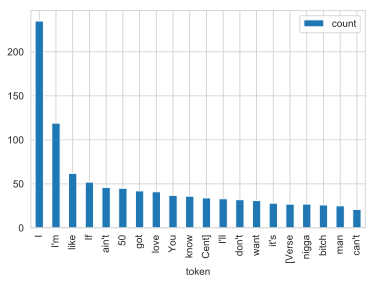

In [88]:
from matplotlib import pyplot as plt

import seaborn as sns

# convert list of tuples into data frame
freq_df = pd.DataFrame.from_records(counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
freq_df.plot(kind='bar', x='token');


In [104]:
s3 = boto3.client('s3')

s3.create_bucket(Bucket='edem-sm-bucket')



{'ResponseMetadata': {'RequestId': '742889C5681D4891',
  'HostId': 'fgpUrVEVXpkjwjX2K01V1O9XvhnT4JHsF3/jYqZYEySe/NIk6PX17Pe2OJbXexvyUTTSItetlUc=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'fgpUrVEVXpkjwjX2K01V1O9XvhnT4JHsF3/jYqZYEySe/NIk6PX17Pe2OJbXexvyUTTSItetlUc=',
   'x-amz-request-id': '742889C5681D4891',
   'date': 'Wed, 20 Nov 2019 00:26:12 GMT',
   'location': '/edem-sm-bucket',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'Location': '/edem-sm-bucket'}

In [107]:
s3.upload_file('music_backup.csv', 'edem-sm-bucket', 'music_data/music.csv', ExtraArgs={'ACL':'public-read'})

In [247]:
lyric_df[lyric_df['lyrics']=='Money']

lyric_df[['artist','lyrics', 'Cleaned Text']].sample(2)

,artist,lyrics,Cleaned Text
1,Tool,[Verse 1]\nBlack\nThen\nWhite are\nAll I see\n...,[vers 1] black then white all i see in infanc ...
0,Tool,[Verse 1]\nTheres a shadow just behind me\nShr...,[vers 1] there shadow behind shroud everi step...


In [200]:
def clean_html(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def clean_punc(word):
    cleaned = re.sub(r'[?|!|\'|#]', r'', word)
    cleaned = re.sub(r'[.|,|)|(|\|/]', r' ', cleaned)
    return cleaned

def text_preprocess(sentence):
    filtered_sentence = []
    for word in sentence.split():
        if word not in stop:
            s = sno.stem(word.lower())
            filtered_sentence.append(s)
        else:
            continue 
    return ' '.join(filtered_sentence)

lyric_df['lyrics']  = lyric_df['lyrics'].apply(clean_punc)
lyric_df['lyrics']  = lyric_df['lyrics'].apply(clean_html)
lyric_df['Cleaned Text']  = lyric_df['lyrics'].apply(text_preprocess)



# for sentence in lyric_df['lyrics'].values:
#     filtered_sentence = []
#     sentence = clean_html(sentence)
#     for word in sentence.split():
#         for cleaned_word in clean_punc(word).split():
#             if (cleaned_word.isalpha() and (len(cleaned_word) > 2) and cleaned_word not in stop):
#                 s = (sno.stem(cleaned_word.lower())).encode('utf8')
#                 filtered_sentence.append(s)
#             else:
#                 continue
                 
#     strl = b' '.join(filtered_sentence)
#     final_string.append(strl)

# lyric_df['Cleaned Text'] = final_string

In [201]:
lyric_df
#save to disk

,lyrics,artist,song,Cleaned Text
0,[Verse 1]\nTheres a shadow just behind me\nShr...,Tool,Sober,[vers 1] there shadow behind shroud everi step...
1,[Verse 1]\nBlack\nThen\nWhite are\nAll I see\n...,Tool,Lateralus,[vers 1] black then white all i see in infanc ...
2,[Verse 1: Lil Yachty]\nDont you hate when a bi...,Carnage,Mase in ’97,[vers 1: lil yachty] dont hate bitch think nee...
3,[Chorus: Lil Uzi Vert]\nI turn five to a ten ...,Carnage,WDYW,[chorus: lil uzi vert] i turn five ten i turn ...


In [203]:
cv = CountVectorizer()
df = cv.fit_transform(lyric_df['Cleaned Text'])

count_vect_df_clean = pd.DataFrame(df.todense(), columns=['vec_' + i for i in cv.get_feature_names()])

count_vect_df_clean
# lyric_df = lyric_df.join(count_vect_df_clean)

# lyric_df

,vec_30,vec_40ll,vec_across,vec_actavi,vec_afghanistan,vec_aint,vec_all,vec_alvin,vec_analyz,vec_and,...,vec_woadi,vec_wont,vec_work,vec_worthless,vec_wrappin,vec_xan,vec_yachty,vec_yellow,vec_you,vec_youngin
0,0,0,0,0,0,0,0,0,0,0,...,0,4,1,2,0,0,0,0,0,0
1,0,0,1,0,0,0,2,0,2,3,...,0,0,0,0,0,0,0,2,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,4,0,1,0
3,1,1,0,1,1,1,0,0,0,0,...,8,0,0,0,1,1,0,0,2,1


In [131]:
music_df = lyric_df

#print(artist_df)
#print(music_df)

In [ ]:
#music_df.to_csv("music.csv", index=False)


In [132]:
averaged_df = music_df.drop(['song','lyrics'],axis=1).groupby('artist').mean().reset_index()



In [133]:
from sklearn.metrics.pairwise import cosine_similarity
query='Weezer'
match = averaged_df[averaged_df['artist']==query]
rest_of_entries = averaged_df[averaged_df['artist']!=query].copy()

if match.empty:\
    print('Not Found!')
    #Throw something here
    #return None
print(cosine_similarity(match.loc[:, match.columns != 'artist'],rest_of_entries.loc[:,rest_of_entries.columns!='artist']))
rest_of_entries['similarity'] = cosine_similarity(match.loc[:, match.columns != 'artist'],rest_of_entries.loc[:,rest_of_entries.columns!='artist'])[0]
rest_of_entries

Not Found!


ValueError: Found array with 0 sample(s) (shape=(0, 629)) while a minimum of 1 is required by check_pairwise_arrays.

In [140]:
cosine_similarity(averaged_df.drop('artist',axis=1),averaged_df.drop('artist',axis=1))

array([[1.        , 0.82064323, 0.70700936, ..., 0.74918614, 0.69364512,
        0.6932935 ],
       [0.82064323, 1.        , 0.76728803, ..., 0.74985765, 0.69923893,
        0.67478045],
       [0.70700936, 0.76728803, 1.        , ..., 0.61287631, 0.54991866,
        0.56922461],
       ...,
       [0.74918614, 0.74985765, 0.61287631, ..., 1.        , 0.79791777,
        0.74379076],
       [0.69364512, 0.69923893, 0.54991866, ..., 0.79791777, 1.        ,
        0.7816415 ],
       [0.6932935 , 0.67478045, 0.56922461, ..., 0.74379076, 0.7816415 ,
        1.        ]])

In [134]:
averaged_df

,artist,vec_abajo,vec_allant,vec_alliag,vec_altess,vec_alway,vec_anoth,vec_apart,vec_aprieta,vec_aprè,...,vec_zipett,vec_âge,vec_ça,vec_écout,vec_écrit,vec_éloquent,vec_érigé,vec_était,vec_êtr,vec_île
0,Deorro,0.5,0.0,0.0,0.0,0.5,0.5,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Hayce Lemsi,0.0,0.5,0.5,1.0,0.0,0.0,0.0,0.0,0.5,...,0.5,0.5,1.0,0.5,0.5,0.5,2.0,1.0,1.0,0.5


In [135]:
def pull_genre(row):
    artist=row['artist'].replace(' ', '%20')
    CLIENT_ID = secrets['spotify_id']
    CLIENT_SECRET = secrets['spotify_secret']

    grant_type = 'client_credentials'
    body_params = {'grant_type' : grant_type}

    url='https://accounts.spotify.com/api/token'
    response = requests.post(url, data=body_params, auth = (CLIENT_ID, CLIENT_SECRET)) 

    token_raw = json.loads(response.text)
    token = token_raw["access_token"]
    headers = {"Authorization": "Bearer {}".format(token)}
    try:
        r = requests.get(url="https://api.spotify.com/v1/search?q={}&type=artist".format(artist), headers=headers)
        ret = json.loads(r.text)
        return ret['artists']['items'][0]['genres']
    except:
        return []

In [136]:
averaged_df['Genre'] = averaged_df.apply(pull_genre,axis=1)
 
#save to disk

#cosine similarities on genre columns. if there is tie, then consine similarity on lyrics


In [137]:
averaged_df

,artist,vec_abajo,vec_allant,vec_alliag,vec_altess,vec_alway,vec_anoth,vec_apart,vec_aprieta,vec_aprè,...,vec_âge,vec_ça,vec_écout,vec_écrit,vec_éloquent,vec_érigé,vec_était,vec_êtr,vec_île,Genre
0,Deorro,0.5,0.0,0.0,0.0,0.5,0.5,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[big room, dance pop, deep big room, disco hou..."
1,Hayce Lemsi,0.0,0.5,0.5,1.0,0.0,0.0,0.0,0.0,0.5,...,0.5,1.0,0.5,0.5,0.5,2.0,1.0,1.0,0.5,"[francoton, french hip hop, pop urbaine]"


In [182]:
averaged_df.dtypes

artist        object
vec_00       float64
vec_000      float64
vec_01       float64
vec_02       float64
vec_03       float64
vec_04       float64
vec_05       float64
vec_06       float64
vec_08       float64
vec_09       float64
vec_10       float64
vec_100      float64
vec_1000     float64
vec_100k     float64
vec_101      float64
vec_103      float64
vec_105      float64
vec_106      float64
vec_108      float64
vec_10k      float64
vec_10s      float64
vec_10th     float64
vec_11       float64
vec_110      float64
vec_112      float64
vec_116th    float64
vec_11s      float64
vec_11x      float64
vec_12       float64
              ...   
vec_혹해       float64
vec_혼란스러     float64
vec_홀로       float64
vec_화나면      float64
vec_화만       float64
vec_효도       float64
vec_후회       float64
vec_후회하는     float64
vec_후회하지     float64
vec_훔쳐       float64
vec_훔쳐보다가    float64
vec_흉터들로     float64
vec_흐르게      float64
vec_흐르는      float64
vec_흔들면      float64
vec_흔들어도     float64
vec_흔한       

In [183]:
len(averaged_df)

337

In [210]:
averaged_df.count()

artist       337
vec_00       337
vec_000      337
vec_01       337
vec_02       337
vec_03       337
vec_04       337
vec_05       337
vec_06       337
vec_08       337
vec_09       337
vec_10       337
vec_100      337
vec_1000     337
vec_100k     337
vec_101      337
vec_103      337
vec_105      337
vec_106      337
vec_108      337
vec_10k      337
vec_10s      337
vec_10th     337
vec_11       337
vec_110      337
vec_112      337
vec_116th    337
vec_11s      337
vec_11x      337
vec_12       337
            ... 
vec_혹해       337
vec_혼란스러     337
vec_홀로       337
vec_화나면      337
vec_화만       337
vec_효도       337
vec_후회       337
vec_후회하는     337
vec_후회하지     337
vec_훔쳐       337
vec_훔쳐보다가    337
vec_흉터들로     337
vec_흐르게      337
vec_흐르는      337
vec_흔들면      337
vec_흔들어도     337
vec_흔한       337
vec_흘러       337
vec_흘러가는데    337
vec_흘러가버린    337
vec_흩날릴      337
vec_힘든       337
vec_힘들       337
vec_힘들게      337
vec_힘들어진     337
vec_힘은       337
vec_힘을       337
vec_ﬁxed     3

In [189]:
averaged_df[['Genre','artist']].describe(include=np.object).transpose()

,count,unique,top,freq
Genre,337,280,"[contemporary country, country, country road, ...",12
artist,337,337,Imagine Dragons,1


In [218]:
df_genre_artist = averaged_df[['artist','Genre']]



In [219]:
df_genre_artist.describe().transpose()

,count,unique,top,freq
artist,337,337,Imagine Dragons,1
Genre,337,280,"[contemporary country, country, country road, ...",12


In [224]:
df_genre_artist[['artist']].plot(kind='box', vert=False, figsize=(6,2));

TypeError: Empty 'DataFrame': no numeric data to plot

In [214]:
# cv = CountVectorizer()
# df = cv.fit_transform(lyric_df['Cleaned Text'])

# count_vect_df_clean = pd.DataFrame(df.todense(), columns=['vec_' + i for i in cv.get_feature_names()])
# lyric_df = lyric_df.join(count_vect_df_clean)

# lyric_df
x = df_genre_artist['Genre']

tuple(e) for e in x

df_genre = cv.fit_transform(x)

count_vect_df_genre = pd.DataFrame(df_genre.todense(), columns=['vec_' + i for i in cv.get_feature_names()])

count_vect_df_genre
# df_genre_artist = df_genre_artist.join(count_vect_df_genre)

# df_genre_artist

SyntaxError: invalid syntax (<ipython-input-214-c599c19fdda1>, line 10)

In [217]:
#averaged_df[['Genre']].nunique()

In [89]:
#averaged_df.to_csv("artist.csv", index=False)
#averaged_df = pd.read_csv("artist.csv")


In [238]:
sub_df=lyric_df[lyric_df['lyrics']=='Love']

In [239]:
sub_df

,lyrics,artist,song,Cleaned Text,vec_30,vec_40ll,vec_across,vec_actavi,vec_afghanistan,vec_aint,...,vec_woadi,vec_wont,vec_work,vec_worthless,vec_wrappin,vec_xan,vec_yachty,vec_yellow,vec_you,vec_youngin
